# Mapping of temporary functions

*RUN IN* `jaspy_plus_s3fs`


If we chunk all of our numpy inputs (or extract them from xarray Datasets), then we have dask arrays that are chunked.

Arbitrary functions can be mapped over these, but those functions must solely accept chunks (smaller numpy arrays). They don't accept other input argument data types.

Therefore, I have a three-stage plan to perform the DDA on dask chunked arrays, whilst maintaining the ability to perform them on simple numpy arrays.
1. Have functions that accept numpy arrays and other inputs. Functions will output variables that change along the considered 'x' (0th) dimension of the data.
2. For desired parameters to these functions, temporary functions can be created that only accept data chunked along the 'x' (0th) data dimension, call the specified function with set parameters, and return a single array along the chunking dimension.
3. Apply these temporary functions to chunked arrays using map_blocks or map_overlap depending on how "locally" the function can be defined along the 0th dimension.

## Initial imports, dask gateway, and data loading

In [1]:
import xarray as xr
import hvplot.xarray
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import datetime as dt

import os
import pathlib

import dask
import dask_gateway

In [2]:
import dda_atmos as dda

In [3]:
#print(dda.steps.calc_density) # testing dda-atmos is properly loaded

In [4]:
''' Cell blocked for purposes of not running gateway, as it doesn't allow for complete computation...
# Create a connection to dask-gateway.
gw = dask_gateway.Gateway("https://dask-gateway.jasmin.ac.uk", auth="jupyterhub")

# Inspect and change the options if required before creating your cluster.
options = gw.cluster_options()
options.worker_cores = 2

# Create a dask cluster, or, if one already exists, connect to it.
# This stage creates the scheduler job in SLURM, so may take some time.
# While your job queues.
clusters = gw.list_clusters()
if not clusters:
    cluster = gw.new_cluster(options, shutdown_on_close=False)
else:
    cluster = gw.connect(clusters[0].name)

# Create at least one worker, and allow your cluster to scale to three.
cluster.adapt(minimum=1, maximum=3)

# Get a dask client.
client = cluster.get_client()

client
'''

' Cell blocked for purposes of not running gateway, as it doesn\'t allow for complete computation...\n# Create a connection to dask-gateway.\ngw = dask_gateway.Gateway("https://dask-gateway.jasmin.ac.uk", auth="jupyterhub")\n\n# Inspect and change the options if required before creating your cluster.\noptions = gw.cluster_options()\noptions.worker_cores = 2\n\n# Create a dask cluster, or, if one already exists, connect to it.\n# This stage creates the scheduler job in SLURM, so may take some time.\n# While your job queues.\nclusters = gw.list_clusters()\nif not clusters:\n    cluster = gw.new_cluster(options, shutdown_on_close=False)\nelse:\n    cluster = gw.connect(clusters[0].name)\n\n# Create at least one worker, and allow your cluster to scale to three.\ncluster.adapt(minimum=1, maximum=3)\n\n# Get a dask client.\nclient = cluster.get_client()\n\nclient\n'

In [5]:
STORE = pathlib.Path('/') / 'gws' / 'nopw' / 'j04' / 'icecaps' / 'ICECAPSarchive' / 'mpl' / 'zarrchive' / '202208.zarr'
CHUNK = {'time': 10000}

tslice = slice(dt.date(2022,8,10), dt.date(2022,8,12))

In [6]:
ds = xr.open_dataset(STORE, engine='zarr').sel(time=tslice).chunk(CHUNK)

In [7]:
ds

<xarray.Dataset>
Dimensions:          (time: 34561, height: 1200)
Coordinates:
  * height           (height) float64 -3e+03 -2.985e+03 ... 1.496e+04 1.497e+04
  * time             (time) datetime64[ns] 2022-08-10T00:00:03 ... 2022-08-12
Data variables: (12/19)
    alt              float32 ...
    backscatter_1    (time, height) float32 dask.array<chunksize=(10000, 1200), meta=np.ndarray>
    backscatter_2    (time, height) float32 dask.array<chunksize=(10000, 1200), meta=np.ndarray>
    base_time        datetime64[ns] ...
    energy           (time) float32 dask.array<chunksize=(10000,), meta=np.ndarray>
    hour             (time) float32 dask.array<chunksize=(10000,), meta=np.ndarray>
    ...               ...
    sd_background_1  (time) float32 dask.array<chunksize=(10000,), meta=np.ndarray>
    sd_background_2  (time) float32 dask.array<chunksize=(10000,), meta=np.ndarray>
    temp_detector    (time) float32 dask.array<chunksize=(10000,), meta=np.ndarray>
    temp_laser       (time) float32 dask.array<chunksize=(10000,), meta=np.ndarray>
    temp_telescope   (time) float32 dask.array<chunksize=(10000,), meta=np.ndarray>
    time_offset      (time) timedelta64[ns] dask.array<chunksize=(10000,), meta=np.ndarray>
Attributes:
    Author:                    Dave Turner, NOAA National Severe Storms Labor...
    Conventions:               CF-1.11-draft
    Date_created:              2023-09-18T18:22:12 UTC
    Ingest_version:            Id: mplgz2ingested/steps/raw_to_ingested.py ,v...
    backscatter_comment:       See Flynn et al. 2007 Optics Express paper for...
    comment:                   DOE Atmospheric Radiation Measurement (ARM) Mi...
    instrument_serial_number:  108
    instrument_version:        413

## creating chunked arrays for use in DDA

This section will create the chunked dask arrays from the xarray Dataset. They could simillarly be created directly from numpy arrays using `dask.Array()`.

NOTE: as `height` isn't chunked along the x-axis, we will simply keep it loaded as an `np.array`, to save on overhead computation.

In [8]:
# for a first pass, only data/signal is truly needed, but for the sake of transparency, I'll load heights too.

signal = ds.backscatter_1.data

height = ds.height.values
print(height.shape, type(height))

print(type(signal))
signal

(1200,) <class 'numpy.ndarray'>
<class 'dask.array.core.Array'>


dask.array<xarray-backscatter_1, shape=(34561, 1200), dtype=float32, chunksize=(10000, 1200), chunktype=numpy.ndarray>

## Input parameters for the DDA

We'll define the parameters for the DDA algorithm. We'll also pre-compute the kernel and other static variables used, to save on memory and computation overhead.

In [9]:
kernal_args = {
    'sigma_y': 90, # pixel-wise if dy is unspecified
    'dy': 15, # in m. Thus, we expect 6 bins to account for 90m
    'sigma_x': 30, # estimated typical change time in seconds
    'dx': 5, # in seconds
    'cutoff': 1
}

density_args = {}

threshold_args = {
    'bias': 0.3,
    'sensitivity': 0.8,
    'quantile': 90
}

In [10]:
kernal = dda.steps.create_kernal.Gaussian(**kernal_args)
kernal.shape

(13, 13)

In [11]:
# for use in map_overlap functions on the dask arrays

DEPTH = {0:kernal.shape[0]//2, 1:0}

BOUNDARY = {0:'reflect', 1:'reflect'}

DEPTH

{0: 6, 1: 0}

## creating temporary functions

In this section, we'll define the temporary functions that only accept chunks for their inputs, that can be used for the mapping functions.
1. ch_calc_density(ch_data, ch_data_mask) will accept chunked data, data_mask, and will have the kernal and parameters pre-defined.
2. ch_calc_threshold(ch_density, ch_data_mask) will accept the chunked density and data_mask inputs.
3. ch_calc_cloud_mask(ch_density, ch_thresholds, ch_data_mask) will accept the chunked density, threshold and data_mask variables.

The cloud_mask can then be computed at the end...

In [12]:
def ch_calc_density(ch_data, ch_data_mask):
    '''Function to calculate chunked density field from the chunked data and data_mask.
    Should be called via map_overlap to ensure edges effects at chunk edges are avoided due to convolution.'''
    return dda.steps.calc_density(ch_data, ch_data_mask, kernal, density_args, verbose=False)

In [13]:
def ch_calc_threshold(ch_density, ch_data_mask):
    '''Function to calculate the chunked threshold parameters.
    Should be called via map_overlap as the rolling quantile window will experience chunk-edge effects due to its width.'''
    return dda.steps.calc_threshold(ch_density, ch_data_mask, **threshold_args, verbose=False)

In [14]:
def ch_calc_cloud_mask(ch_density, ch_threshold, ch_data_mask):
    '''Function to calculate the chunked cloud_mask variable.
    Can be called via map_blocks as is a completely "local" function.'''
    return dda.steps.calc_cloud_mask(ch_density, ch_threshold, ch_data_mask, remove_small_clusters=0, verbose=False)

## Threading the algorithm

Now that we have temporary functions setup with the required input parameters, we can perform the DDA calculations.

In [15]:
data_mask = np.isnan(signal)


#g1 = dask.array.overlap.overlap(signal, depth=DEPTH, boundary=BOUNDARY)
#g2 = dask.array.overlap.overlap(data_mask, depth=DEPTH, boundary=BOUNDARY)
#g3 = dask.array.map_blocks(ch_calc_density, g1,g2)
#density = dask.array.overlap.trim_overlap(g3, DEPTH, BOUNDARY)


density = dask.array.overlap.map_overlap(ch_calc_density, signal, data_mask, depth=DEPTH, boundary=BOUNDARY)

density

dask.array<_trim, shape=(34561, 1200), dtype=float64, chunksize=(10000, 1200), chunktype=numpy.ndarray>

In [16]:
%%time
#g1.compute()
#g2.compute()
#g3.compute()
#out1 = density.compute()
density = density.persist()

CPU times: user 55.1 s, sys: 5.23 s, total: 1min
Wall time: 56 s


In [17]:
%%time
#density_direct = dask.array.overlap.map_overlap(ch_calc_density, signal, data_mask, depth=DEPTH, boundary=BOUNDARY)
#out2 = density_direct.compute()

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 10.5 µs


In [18]:
#plt.imshow(out1 == out2)

In [19]:
#print(np.sum(out1 != out2))

In [20]:
threshold = dask.array.overlap.map_overlap(ch_calc_threshold, density, data_mask, depth=DEPTH, boundary=BOUNDARY, drop_axis=1, new_axis=1)

cloud_mask = dask.array.map_blocks(ch_calc_cloud_mask, density, threshold, data_mask, dtype=bool)

cloud_mask

dask.array<ch_calc_cloud_mask, shape=(34561, 1200), dtype=bool, chunksize=(10000, 1200), chunktype=numpy.ndarray>

In [21]:
%%time
#threshold.compute()
threshold = threshold.persist()

CPU times: user 5.23 s, sys: 1.9 s, total: 7.13 s
Wall time: 5.51 s


In [22]:
threshold

dask.array<_trim, shape=(34561, 1), dtype=float64, chunksize=(10000, 1), chunktype=numpy.ndarray>

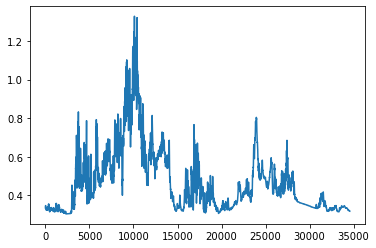

In [23]:
plt.plot(threshold)

In [24]:
%%time
#cloud_mask.compute()
cloud_mask = cloud_mask.persist()

CPU times: user 5.02 s, sys: 1.75 s, total: 6.77 s
Wall time: 5.23 s


In [25]:
ds['cloud_mask'] = (('time','height'), cloud_mask)
ds

<xarray.Dataset>
Dimensions:          (time: 34561, height: 1200)
Coordinates:
  * height           (height) float64 -3e+03 -2.985e+03 ... 1.496e+04 1.497e+04
  * time             (time) datetime64[ns] 2022-08-10T00:00:03 ... 2022-08-12
Data variables: (12/20)
    alt              float32 3.2e+03
    backscatter_1    (time, height) float32 dask.array<chunksize=(10000, 1200), meta=np.ndarray>
    backscatter_2    (time, height) float32 dask.array<chunksize=(10000, 1200), meta=np.ndarray>
    base_time        datetime64[ns] 2022-08-01T00:00:01
    energy           (time) float32 dask.array<chunksize=(10000,), meta=np.ndarray>
    hour             (time) float32 dask.array<chunksize=(10000,), meta=np.ndarray>
    ...               ...
    sd_background_2  (time) float32 dask.array<chunksize=(10000,), meta=np.ndarray>
    temp_detector    (time) float32 dask.array<chunksize=(10000,), meta=np.ndarray>
    temp_laser       (time) float32 dask.array<chunksize=(10000,), meta=np.ndarray>
    temp_telescope   (time) float32 dask.array<chunksize=(10000,), meta=np.ndarray>
    time_offset      (time) timedelta64[ns] dask.array<chunksize=(10000,), meta=np.ndarray>
    cloud_mask       (time, height) bool dask.array<chunksize=(10000, 1200), meta=np.ndarray>
Attributes:
    Author:                    Dave Turner, NOAA National Severe Storms Labor...
    Conventions:               CF-1.11-draft
    Date_created:              2023-09-18T18:22:12 UTC
    Ingest_version:            Id: mplgz2ingested/steps/raw_to_ingested.py ,v...
    backscatter_comment:       See Flynn et al. 2007 Optics Express paper for...
    comment:                   DOE Atmospheric Radiation Measurement (ARM) Mi...
    instrument_serial_number:  108
    instrument_version:        413

In [ ]:
%%time
ds.cloud_mask.plot(x='time')

In [ ]:
%%time
ds.backscatter_1.plot(x='time', robust=True, cmap='viridis')

In [26]:
ds['density'] = (('time','height'), density)
ds['threshold'] = (('time'), np.squeeze(threshold))
ds

<xarray.Dataset>
Dimensions:          (time: 34561, height: 1200)
Coordinates:
  * height           (height) float64 -3e+03 -2.985e+03 ... 1.496e+04 1.497e+04
  * time             (time) datetime64[ns] 2022-08-10T00:00:03 ... 2022-08-12
Data variables: (12/22)
    alt              float32 3.2e+03
    backscatter_1    (time, height) float32 dask.array<chunksize=(10000, 1200), meta=np.ndarray>
    backscatter_2    (time, height) float32 dask.array<chunksize=(10000, 1200), meta=np.ndarray>
    base_time        datetime64[ns] 2022-08-01T00:00:01
    energy           (time) float32 dask.array<chunksize=(10000,), meta=np.ndarray>
    hour             (time) float32 dask.array<chunksize=(10000,), meta=np.ndarray>
    ...               ...
    temp_laser       (time) float32 dask.array<chunksize=(10000,), meta=np.ndarray>
    temp_telescope   (time) float32 dask.array<chunksize=(10000,), meta=np.ndarray>
    time_offset      (time) timedelta64[ns] dask.array<chunksize=(10000,), meta=np.ndarray>
    cloud_mask       (time, height) bool dask.array<chunksize=(10000, 1200), meta=np.ndarray>
    density          (time, height) float64 dask.array<chunksize=(10000, 1200), meta=np.ndarray>
    threshold        (time) float64 dask.array<chunksize=(10000,), meta=np.ndarray>
Attributes:
    Author:                    Dave Turner, NOAA National Severe Storms Labor...
    Conventions:               CF-1.11-draft
    Date_created:              2023-09-18T18:22:12 UTC
    Ingest_version:            Id: mplgz2ingested/steps/raw_to_ingested.py ,v...
    backscatter_comment:       See Flynn et al. 2007 Optics Express paper for...
    comment:                   DOE Atmospheric Radiation Measurement (ARM) Mi...
    instrument_serial_number:  108
    instrument_version:        413

In [ ]:
%%time
ds.density.plot(x='time', robust=True, cmap='viridis')

In [ ]:
%%time
ds.threshold.plot()

In [ ]:
(ds.density - ds.backscatter_1).plot(x='time', robust=True)

In [27]:
ds

<xarray.Dataset>
Dimensions:          (time: 34561, height: 1200)
Coordinates:
  * height           (height) float64 -3e+03 -2.985e+03 ... 1.496e+04 1.497e+04
  * time             (time) datetime64[ns] 2022-08-10T00:00:03 ... 2022-08-12
Data variables: (12/22)
    alt              float32 3.2e+03
    backscatter_1    (time, height) float32 dask.array<chunksize=(10000, 1200), meta=np.ndarray>
    backscatter_2    (time, height) float32 dask.array<chunksize=(10000, 1200), meta=np.ndarray>
    base_time        datetime64[ns] 2022-08-01T00:00:01
    energy           (time) float32 dask.array<chunksize=(10000,), meta=np.ndarray>
    hour             (time) float32 dask.array<chunksize=(10000,), meta=np.ndarray>
    ...               ...
    temp_laser       (time) float32 dask.array<chunksize=(10000,), meta=np.ndarray>
    temp_telescope   (time) float32 dask.array<chunksize=(10000,), meta=np.ndarray>
    time_offset      (time) timedelta64[ns] dask.array<chunksize=(10000,), meta=np.ndarray>
    cloud_mask       (time, height) bool dask.array<chunksize=(10000, 1200), meta=np.ndarray>
    density          (time, height) float64 dask.array<chunksize=(10000, 1200), meta=np.ndarray>
    threshold        (time) float64 dask.array<chunksize=(10000,), meta=np.ndarray>
Attributes:
    Author:                    Dave Turner, NOAA National Severe Storms Labor...
    Conventions:               CF-1.11-draft
    Date_created:              2023-09-18T18:22:12 UTC
    Ingest_version:            Id: mplgz2ingested/steps/raw_to_ingested.py ,v...
    backscatter_comment:       See Flynn et al. 2007 Optics Express paper for...
    comment:                   DOE Atmospheric Radiation Measurement (ARM) Mi...
    instrument_serial_number:  108
    instrument_version:        413

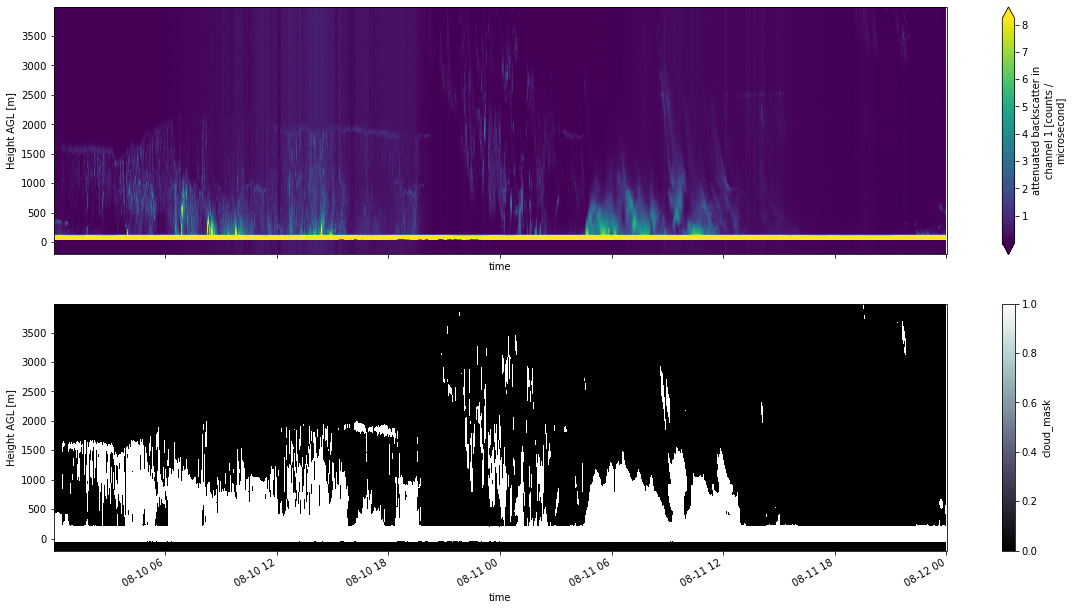

In [30]:
fig, axs = plt.subplots(2,1,figsize=(20,10), sharex=True)

ds_plot = ds.sel(height=slice(-200,4000))


f_alph = 0.2 + 0.8*ds.cloud_mask

ds_plot.backscatter_1.plot(x='time', robust=True, cmap='viridis', ax=axs[0])
#ds_plot.density.plot(x='time', robust=True, cmap='viridis', ax=axs[1])
#ds_plot.threshold.plot(ax=axs[2])
ds_plot.cloud_mask.plot(x='time', cmap='bone', ax=axs[1])
#ds_plot.backscatter_1.plot(x='time', robust=True, cmap='viridis', ax=axs[2], alpha=f_alph)

plt.show()